# Optimization WFA - Mutiple Linear Regression

## Mutiple Linear Regression with scikit-learn 

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades

In [3]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from util.Save_result_return import save_to_csv

plt.style.use("seaborn-v0_8")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [5]:
from backtesting import Strategy

In [6]:
import warnings
warnings.simplefilter("ignore")

## Getting the Data

In [7]:
XAUUSD = load_data()

In [8]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [9]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


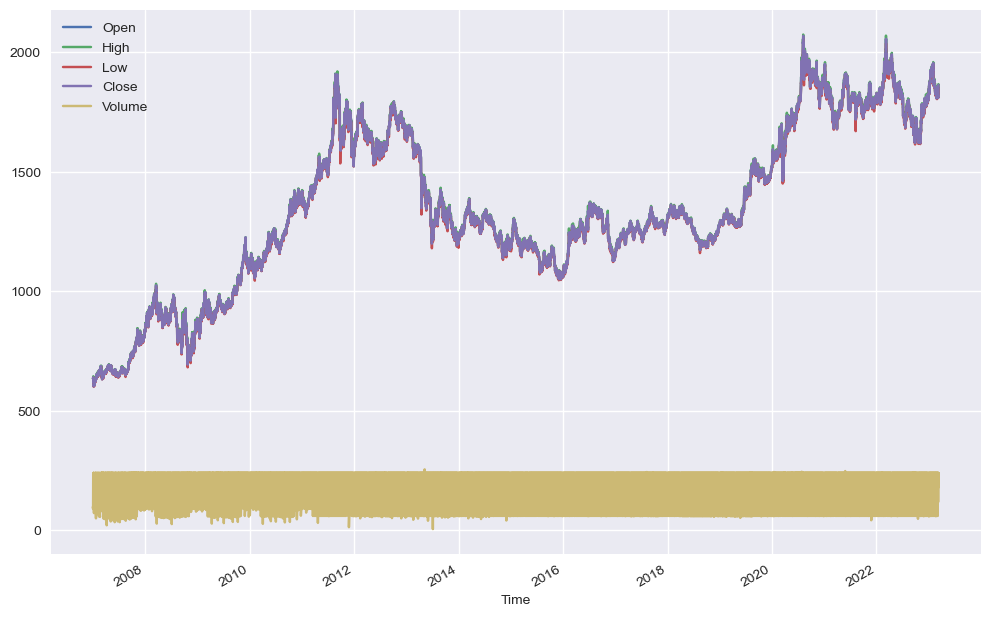

In [10]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [11]:
class Mutiple_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [12]:
mainFolder = 'Machine_Learning'
strategy = Mutiple_Regression
strategyName = 'Mutiple_Regression'
account_size = 10000
folder_ML_Strategy = 'Mutiple_Linear_Regression'
subFolder = 'Optimization'

In [13]:
class ML_Regression():

    def __init__(self, data, strategy, start_train,  end_train,  TF, window_size, account_size):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.end_train = end_train
        self.TF = TF
        self.window_size = window_size
        self.account_size = account_size
        self.data_train = None
        self.results = None
        self.model = None

    def Prepare(self, lags=5):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'] / data['Close'].shift(1))
        data['returns_signal'] = data['returns'].shift(-1)
        # data.dropna(inplace=True)
        cols = []
        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        # data.dropna(inplace=True)
        data.fillna(0, inplace=True)
        data['pred'] = 0

        for i in range(self.window_size, len(data)):
            rolling_window_data = data.iloc[i - self.window_size :i ]

            lm = LinearRegression(fit_intercept=True)
            lm.fit(rolling_window_data[cols],
                   rolling_window_data['returns_signal'])

            # Predict for the next data point
            pred_value = lm.predict(
                np.array(data[cols].iloc[i]).reshape(1, -1))
            data.at[data.index[i], 'pred'] = np.sign(pred_value[0])

        self.model = lm
        self.data_train = data.copy()

    def Backtest(self, data):
        # Assuming you have a Backtest class that performs backtesting
        account_size = self.account_size
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1/100,commission=0.0002)
        result = backtest.run()
        return result

    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)

        return result_train

## TF D1

In [14]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'D1'

### Window size 1 year

In [15]:
data = XAUUSD['D1']
window_size = 252
WFA = '1y'

In [16]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [17]:
test = ml.Run()

In [18]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   94.983145
Equity Final [$]                  9972.310239
Equity Peak [$]                  10232.268531
Return [%]                          -0.276898
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.013855
Volatility (Ann.) [%]                2.140809
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -13.389549
Avg. Drawdown [%]                    -1.75963
Max. Drawdown Duration     4230 days 00:00:00
Avg. Drawdown Duration      400 days 00:00:00
# Trades                                 2038
Win Rate [%]                        50.147203
Best Trade [%]                       9.272037
Worst Trade [%]                    -11.074887
Avg. Trade [%]                    

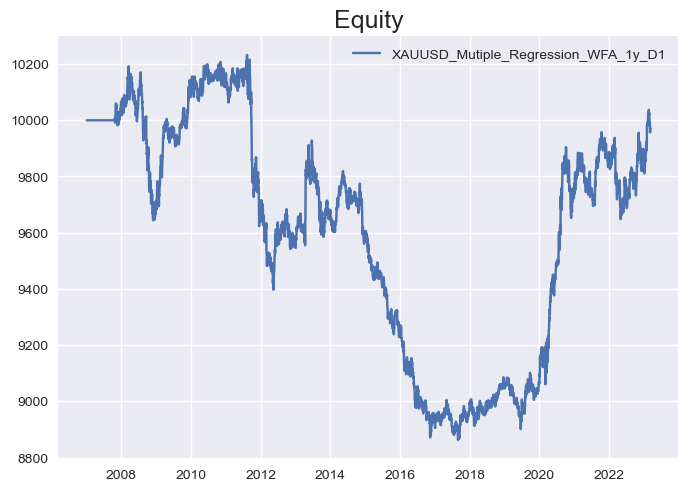

In [19]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [20]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [21]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [22]:
data = XAUUSD['D1']
window_size = 252 * 2
WFA = '2y'

In [23]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [24]:
test = ml.Run()

In [25]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   89.986119
Equity Final [$]                 10311.577575
Equity Peak [$]                  10968.308499
Return [%]                           3.115776
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                    0.153437
Volatility (Ann.) [%]                1.979455
Sharpe Ratio                         0.077515
Sortino Ratio                        0.111244
Calmar Ratio                         0.017057
Max. Drawdown [%]                   -8.995557
Avg. Drawdown [%]                   -1.075723
Max. Drawdown Duration     2643 days 00:00:00
Avg. Drawdown Duration      139 days 00:00:00
# Trades                                 1804
Win Rate [%]                        49.889135
Best Trade [%]                       9.272037
Worst Trade [%]                     -10.99555
Avg. Trade [%]                    

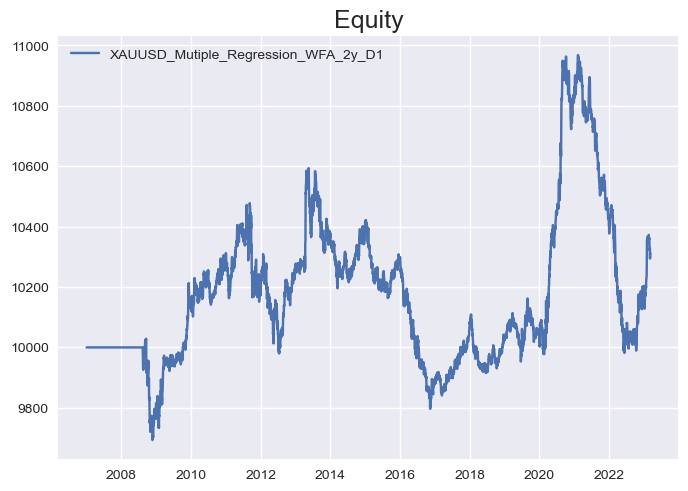

In [26]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [27]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [28]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [29]:
data = XAUUSD['D1']
window_size = 252 * 3
WFA = '3y'

In [30]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [31]:
test = ml.Run()

In [32]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   84.989094
Equity Final [$]                  9141.369961
Equity Peak [$]                  10645.521797
Return [%]                            -8.5863
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.447602
Volatility (Ann.) [%]                1.990277
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -14.636136
Avg. Drawdown [%]                   -0.774485
Max. Drawdown Duration     4202 days 00:00:00
Avg. Drawdown Duration      143 days 00:00:00
# Trades                                 1566
Win Rate [%]                        48.212005
Best Trade [%]                       9.272037
Worst Trade [%]                    -14.847623
Avg. Trade [%]                    

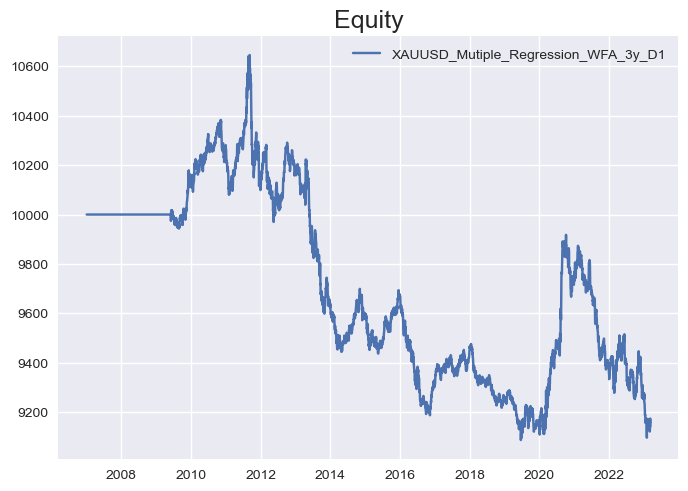

In [33]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [34]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [35]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [36]:
data = XAUUSD['D1']
window_size = 252 * 4
WFA = '4y'

In [37]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [38]:
test = ml.Run()

In [39]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   79.992068
Equity Final [$]                  8813.948269
Equity Peak [$]                  10367.291572
Return [%]                         -11.860517
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.628887
Volatility (Ann.) [%]                  2.0552
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -18.566461
Avg. Drawdown [%]                   -1.782624
Max. Drawdown Duration     4205 days 00:00:00
Avg. Drawdown Duration      315 days 00:00:00
# Trades                                 1544
Win Rate [%]                        48.834197
Best Trade [%]                       7.483838
Worst Trade [%]                    -12.234587
Avg. Trade [%]                    

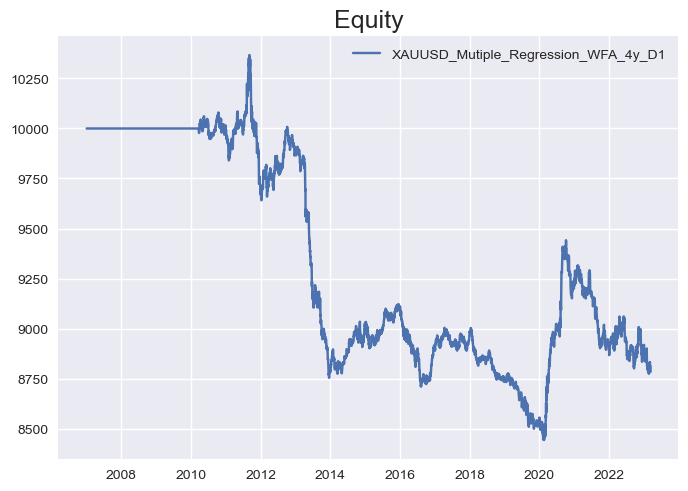

In [40]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [41]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [42]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [43]:
data = XAUUSD['D1']
window_size = 252 * 5
WFA = '5y'

In [44]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [45]:
test = ml.Run()

In [46]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   74.995043
Equity Final [$]                  9095.919097
Equity Peak [$]                  10316.450717
Return [%]                          -9.040809
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.472395
Volatility (Ann.) [%]                1.996237
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -16.61631
Avg. Drawdown [%]                   -1.341413
Max. Drawdown Duration     4218 days 00:00:00
Avg. Drawdown Duration      277 days 00:00:00
# Trades                                 1526
Win Rate [%]                          49.1481
Best Trade [%]                        6.35913
Worst Trade [%]                    -13.528482
Avg. Trade [%]                    

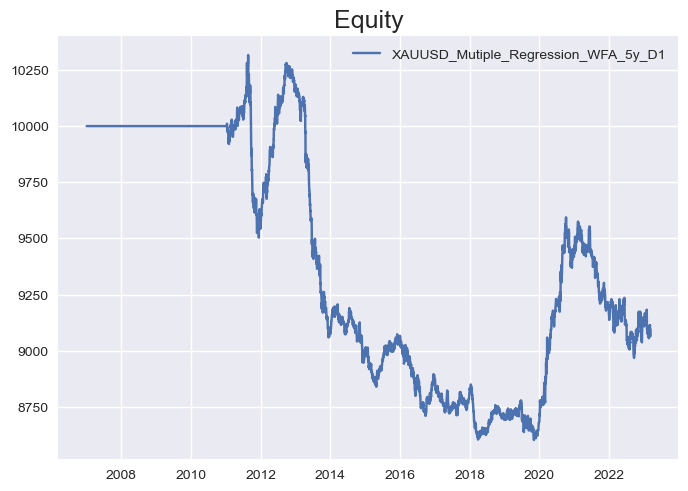

In [47]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [48]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [49]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [50]:
data = XAUUSD['D1']
window_size = 252 * 6
WFA = '6y'

In [51]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [52]:
test = ml.Run()

In [53]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   69.998017
Equity Final [$]                  9540.193625
Equity Peak [$]                  10311.600168
Return [%]                          -4.598064
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                    -0.23494
Volatility (Ann.) [%]                1.778919
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -11.743877
Avg. Drawdown [%]                   -1.088641
Max. Drawdown Duration     3816 days 00:00:00
Avg. Drawdown Duration      243 days 00:00:00
# Trades                                 1422
Win Rate [%]                        50.843882
Best Trade [%]                        6.19387
Worst Trade [%]                    -13.528482
Avg. Trade [%]                    

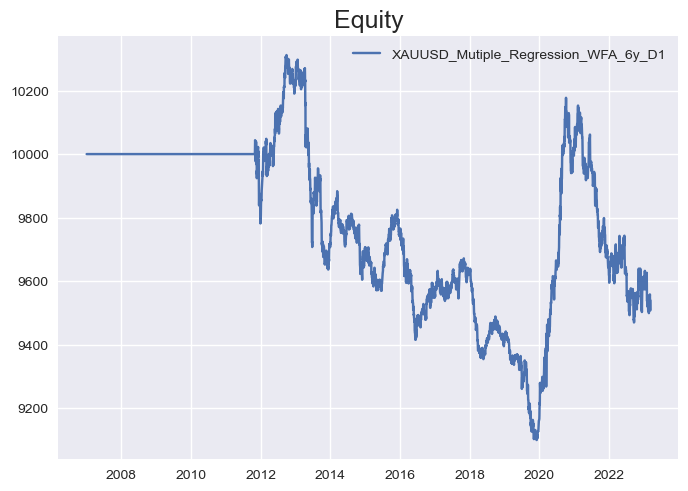

In [54]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [55]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [56]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [57]:
data = XAUUSD['D1']
window_size = 252 * 7
WFA = '7y'

In [58]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [59]:
test = ml.Run()

In [60]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   65.000991
Equity Final [$]                  8614.293421
Equity Peak [$]                  10117.843972
Return [%]                         -13.857066
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.742597
Volatility (Ann.) [%]                1.825535
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -18.725989
Avg. Drawdown [%]                   -2.759163
Max. Drawdown Duration     3816 days 00:00:00
Avg. Drawdown Duration      549 days 00:00:00
# Trades                                 1376
Win Rate [%]                        49.491279
Best Trade [%]                       5.854338
Worst Trade [%]                    -13.528482
Avg. Trade [%]                    

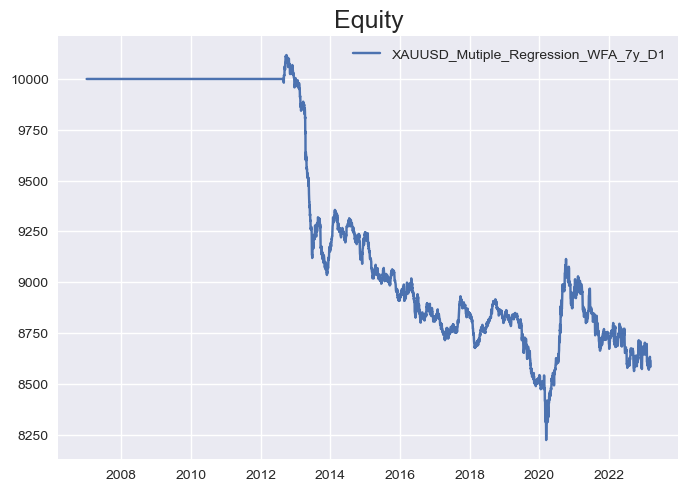

In [61]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [62]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [63]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [64]:
data = XAUUSD['D1']
window_size = 252 * 8
WFA = '8y'

In [65]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [66]:
test = ml.Run()

In [67]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   60.003966
Equity Final [$]                  9369.133596
Equity Peak [$]                  10094.628709
Return [%]                          -6.308664
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.325099
Volatility (Ann.) [%]                1.587712
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                    -9.09745
Avg. Drawdown [%]                   -3.057418
Max. Drawdown Duration     3008 days 00:00:00
Avg. Drawdown Duration      709 days 00:00:00
# Trades                                 1396
Win Rate [%]                        50.143266
Best Trade [%]                       5.854338
Worst Trade [%]                     -7.751037
Avg. Trade [%]                    

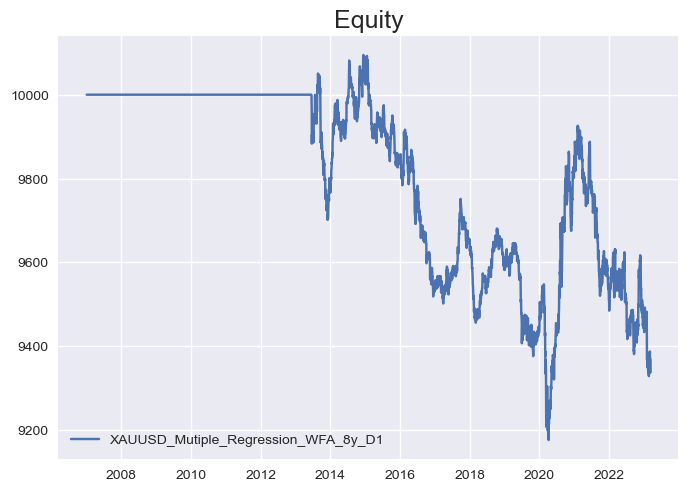

In [68]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [69]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [70]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H4

In [71]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'H4'

### Window size 1 year

In [72]:
data = XAUUSD['H4']
window_size = 252 * 6
WFA = '1y'

In [73]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [74]:
test = ml.Run()

In [75]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   94.175393
Equity Final [$]                  9589.582147
Equity Peak [$]                  11077.076685
Return [%]                          -4.104179
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.209195
Volatility (Ann.) [%]                1.941669
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -14.138702
Avg. Drawdown [%]                   -0.291708
Max. Drawdown Duration     4203 days 00:00:00
Avg. Drawdown Duration       39 days 14:00:00
# Trades                                10869
Win Rate [%]                        49.001748
Best Trade [%]                      11.704432
Worst Trade [%]                     -6.557319
Avg. Trade [%]                    

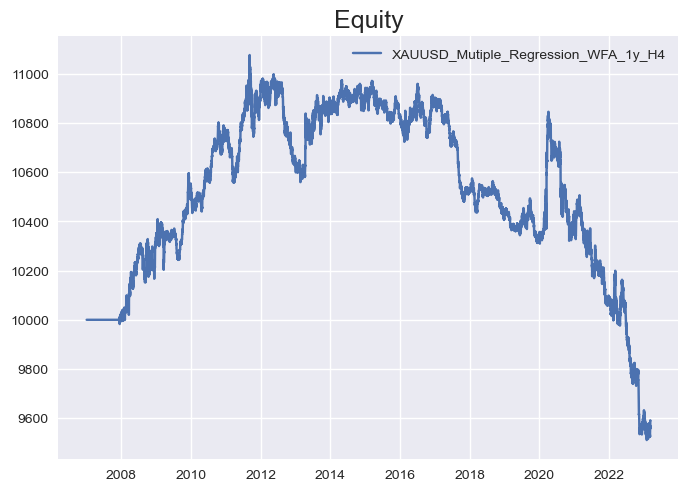

In [76]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [77]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [78]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [79]:
data = XAUUSD['H4']
window_size = 252 * 2 * 6
WFA = '2y'

In [80]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [81]:
test = ml.Run()

In [82]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   88.354635
Equity Final [$]                  8510.134121
Equity Peak [$]                  11398.120089
Return [%]                         -14.898659
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.802916
Volatility (Ann.) [%]                1.884854
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -25.595906
Avg. Drawdown [%]                   -0.272151
Max. Drawdown Duration     3815 days 16:00:00
Avg. Drawdown Duration       26 days 05:00:00
# Trades                                 9985
Win Rate [%]                        48.783175
Best Trade [%]                      10.210369
Worst Trade [%]                     -6.274439
Avg. Trade [%]                    

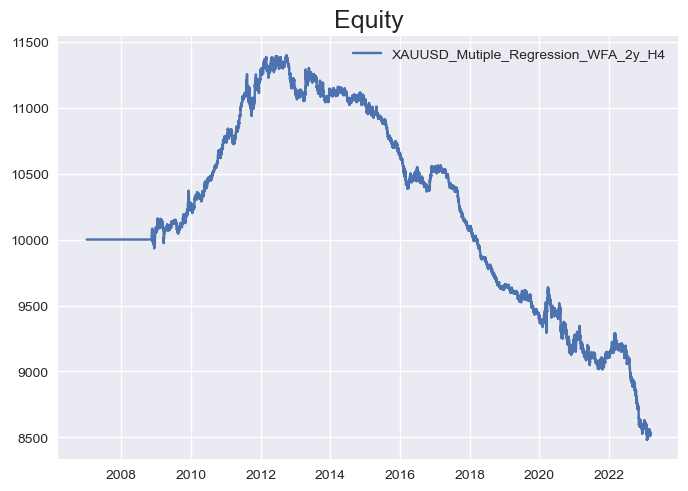

In [83]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [84]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [85]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [86]:
data = XAUUSD['H4']
window_size = 252 * 3 * 6
WFA = '3y'

In [87]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [88]:
test = ml.Run()

In [89]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   82.533877
Equity Final [$]                  8516.804293
Equity Peak [$]                  11098.338617
Return [%]                         -14.831957
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.799033
Volatility (Ann.) [%]                1.845981
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -23.574655
Avg. Drawdown [%]                   -0.304671
Max. Drawdown Duration     3815 days 16:00:00
Avg. Drawdown Duration       31 days 09:00:00
# Trades                                 8869
Win Rate [%]                        49.182546
Best Trade [%]                       8.680607
Worst Trade [%]                     -5.730231
Avg. Trade [%]                    

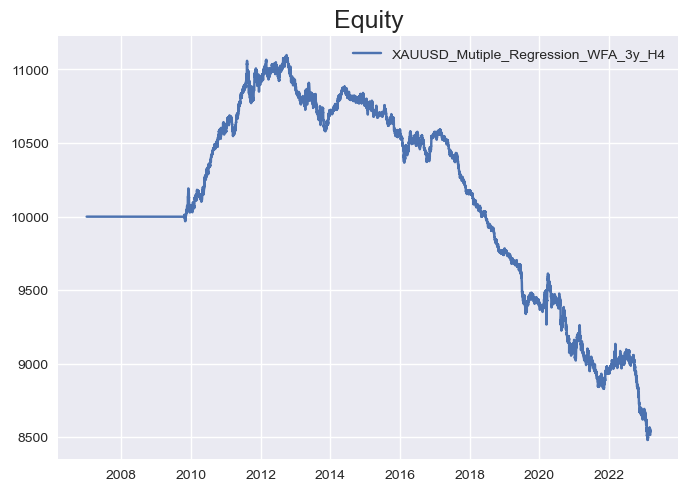

In [90]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [91]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [92]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [93]:
data = XAUUSD['H4']
window_size = 252 * 4 * 6
WFA = '4y'

In [94]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [95]:
test = ml.Run()

In [96]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                    76.71312
Equity Final [$]                  8504.549598
Equity Peak [$]                  11123.129735
Return [%]                         -14.954504
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                    -0.80617
Volatility (Ann.) [%]                1.891414
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -23.860836
Avg. Drawdown [%]                   -0.403687
Max. Drawdown Duration     3851 days 04:00:00
Avg. Drawdown Duration       37 days 09:00:00
# Trades                                 8370
Win Rate [%]                        49.151732
Best Trade [%]                       7.297285
Worst Trade [%]                      -6.32406
Avg. Trade [%]                    

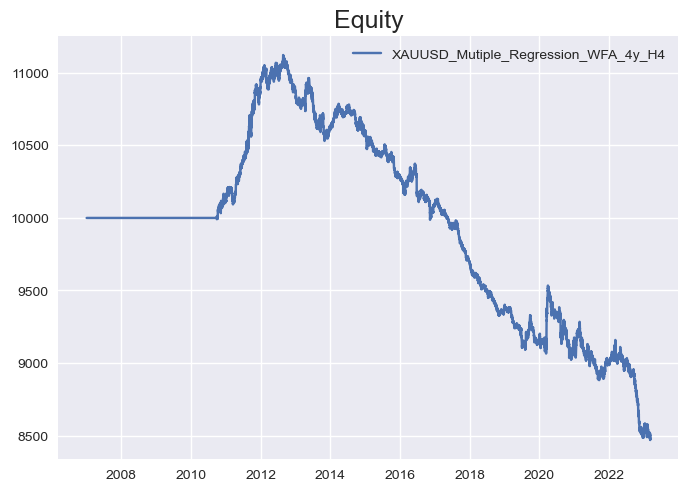

In [97]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [98]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [99]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [100]:
data = XAUUSD['H4']
window_size = 252 * 5 * 6
WFA = '5y'

In [101]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, 500)

In [102]:
test = ml.Run()

In [103]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   38.831999
Equity Final [$]                    10.608342
Equity Peak [$]                   1147.028451
Return [%]                         -97.878332
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                  -17.513353
Volatility (Ann.) [%]               31.984076
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.262499
Avg. Drawdown [%]                   -4.588737
Max. Drawdown Duration     3815 days 00:00:00
Avg. Drawdown Duration       69 days 23:00:00
# Trades                                 4182
Win Rate [%]                        45.528455
Best Trade [%]                       5.377545
Worst Trade [%]                     -5.341217
Avg. Trade [%]                    

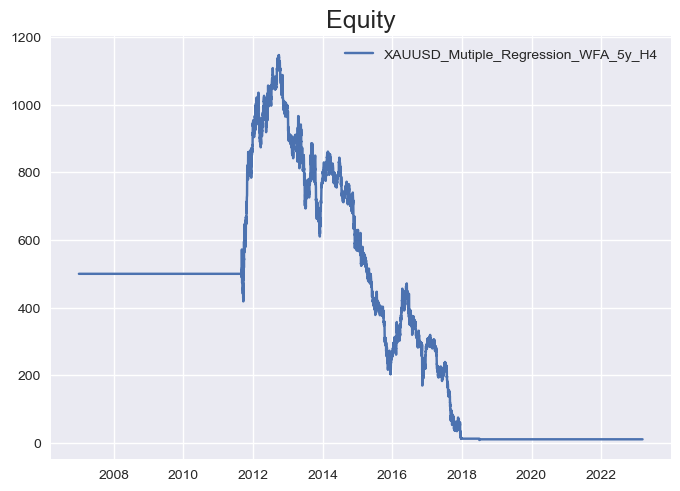

In [104]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [105]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [106]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [107]:
data = XAUUSD['H4']
window_size = 252 * 6 * 6
WFA = '6y'

In [108]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [109]:
test = ml.Run()

In [110]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   65.071605
Equity Final [$]                  8020.766426
Equity Peak [$]                  10097.763724
Return [%]                         -19.792336
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -1.096049
Volatility (Ann.) [%]                1.791442
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -20.998293
Avg. Drawdown [%]                   -1.856938
Max. Drawdown Duration     3815 days 00:00:00
Avg. Drawdown Duration      321 days 15:00:00
# Trades                                 7233
Win Rate [%]                        47.988387
Best Trade [%]                       5.377545
Worst Trade [%]                     -5.730231
Avg. Trade [%]                    

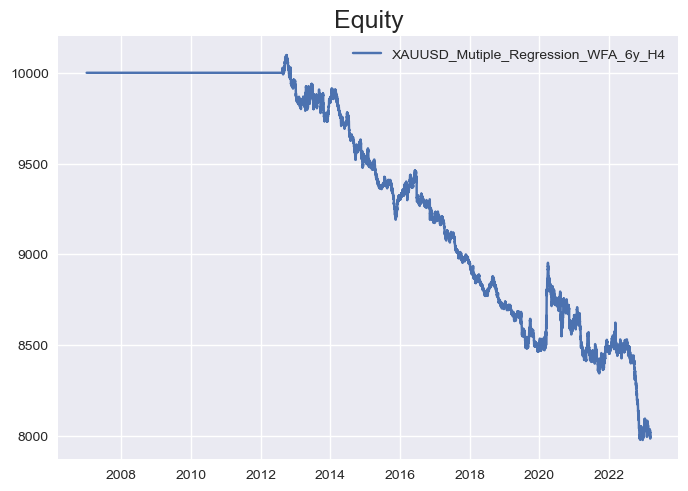

In [111]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [112]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [113]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [114]:
data = XAUUSD['H4']
window_size = 252 * 7 * 6
WFA = '7y'

In [115]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [116]:
test = ml.Run()

In [117]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   59.250847
Equity Final [$]                  8434.129872
Equity Peak [$]                  10062.927937
Return [%]                         -15.658701
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.847376
Volatility (Ann.) [%]                1.573383
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -16.538821
Avg. Drawdown [%]                   -2.273248
Max. Drawdown Duration     3474 days 20:00:00
Avg. Drawdown Duration      439 days 06:00:00
# Trades                                 6583
Win Rate [%]                        48.837916
Best Trade [%]                       3.865197
Worst Trade [%]                     -5.730231
Avg. Trade [%]                    

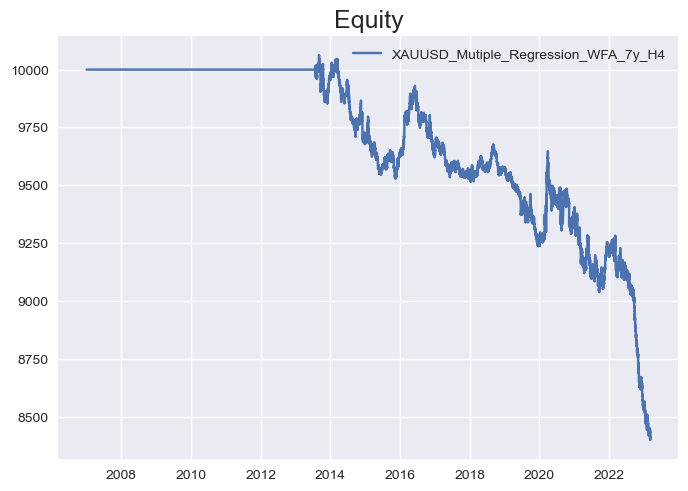

In [118]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [119]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [120]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [121]:
data = XAUUSD['H4']
window_size = 252 * 8 * 6
WFA = '8y'

In [122]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [123]:
test = ml.Run()

In [124]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   53.430089
Equity Final [$]                  7694.041132
Equity Peak [$]                  10002.460657
Return [%]                         -23.059589
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -1.301373
Volatility (Ann.) [%]                1.595861
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -23.433892
Avg. Drawdown [%]                  -23.433892
Max. Drawdown Duration     3168 days 12:00:00
Avg. Drawdown Duration     3168 days 12:00:00
# Trades                                 6033
Win Rate [%]                        48.334162
Best Trade [%]                       5.709938
Worst Trade [%]                     -5.591309
Avg. Trade [%]                    

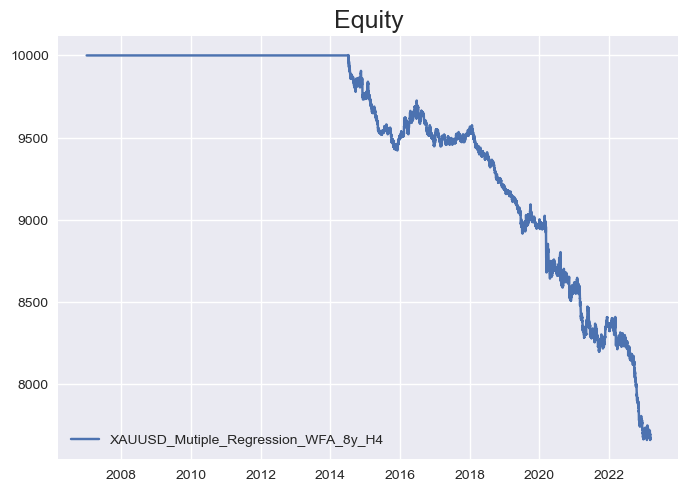

In [125]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [126]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [127]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H1

In [128]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'H1'

### Window size 1 year

In [129]:
data = XAUUSD['H1']
window_size = 252 * 24
WFA = '1y'

In [130]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [131]:
test = ml.Run()

In [132]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   84.230353
Equity Final [$]                    12.641658
Equity Peak [$]                  10119.438893
Return [%]                         -99.873583
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                  -28.356564
Volatility (Ann.) [%]               27.180595
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.875076
Avg. Drawdown [%]                   -3.185554
Max. Drawdown Duration     5516 days 04:00:00
Avg. Drawdown Duration      173 days 18:00:00
# Trades                                38350
Win Rate [%]                        45.259452
Best Trade [%]                       7.210009
Worst Trade [%]                      -4.51213
Avg. Trade [%]                    

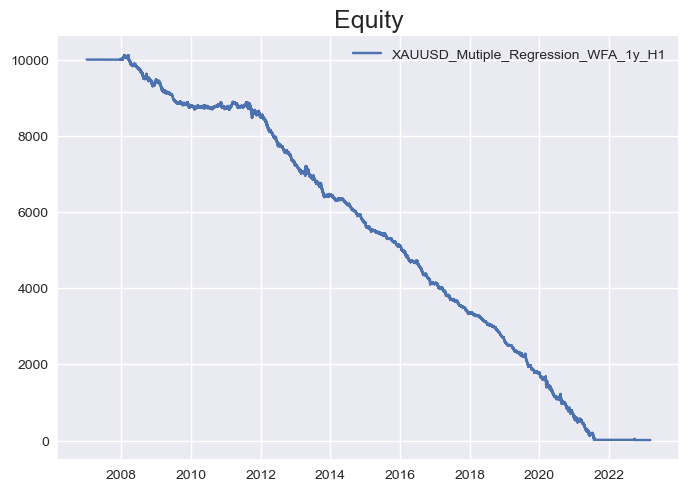

In [133]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [134]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [135]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [136]:
data = XAUUSD['H1']
window_size = 252 * 2 * 24
WFA = '2y'

In [137]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [138]:
test = ml.Run()

In [139]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                    85.64224
Equity Final [$]                    11.854501
Equity Peak [$]                  10067.911121
Return [%]                         -99.881455
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                  -28.586355
Volatility (Ann.) [%]               17.999865
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.882255
Avg. Drawdown [%]                  -12.626618
Max. Drawdown Duration     5184 days 15:00:00
Avg. Drawdown Duration      651 days 01:00:00
# Trades                                39204
Win Rate [%]                        45.444342
Best Trade [%]                       6.236456
Worst Trade [%]                     -4.666537
Avg. Trade [%]                    

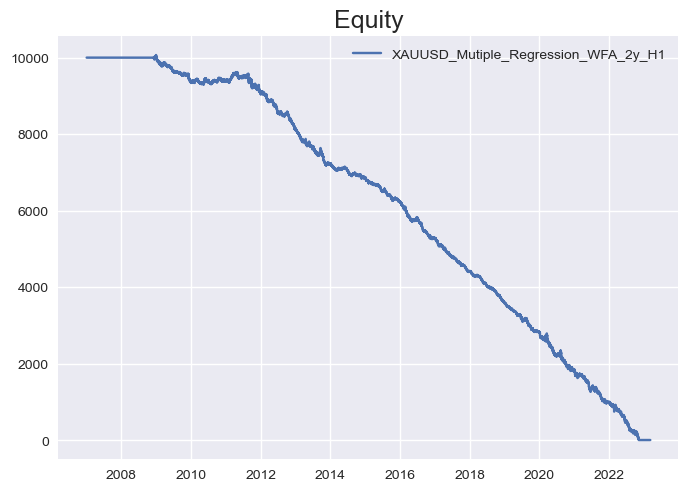

In [140]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [141]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [142]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [143]:
data = XAUUSD['H1']
window_size = 252 * 3 * 24
WFA = '3y'

In [144]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [145]:
test = ml.Run()

In [146]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   81.475999
Equity Final [$]                   683.962015
Equity Peak [$]                  10207.960253
Return [%]                          -93.16038
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                  -12.544677
Volatility (Ann.) [%]                5.728534
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -93.299719
Avg. Drawdown [%]                   -2.058231
Max. Drawdown Duration     4201 days 06:00:00
Avg. Drawdown Duration       95 days 04:00:00
# Trades                                36882
Win Rate [%]                        44.723713
Best Trade [%]                          5.184
Worst Trade [%]                     -5.196242
Avg. Trade [%]                    

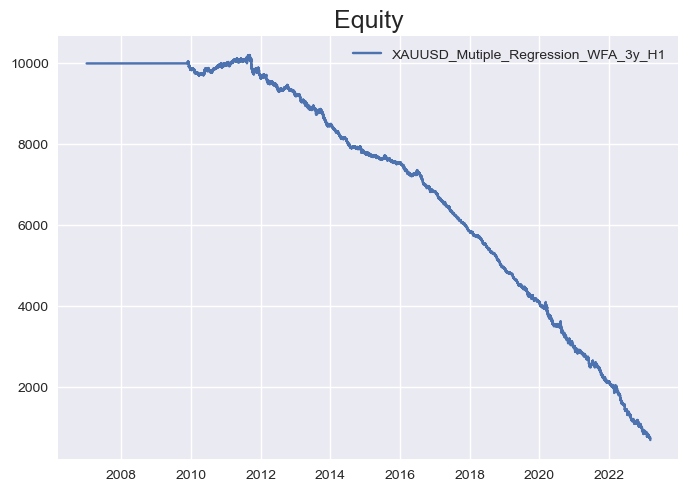

In [147]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [148]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [149]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [150]:
data = XAUUSD['H1']
window_size = 252 * 4 * 24
WFA = '4y'

In [151]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [152]:
test = ml.Run()

In [153]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   75.301672
Equity Final [$]                   474.468547
Equity Peak [$]                  10291.785093
Return [%]                         -95.255315
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                  -14.128362
Volatility (Ann.) [%]                6.447828
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -95.389832
Avg. Drawdown [%]                   -1.781315
Max. Drawdown Duration     4200 days 18:00:00
Avg. Drawdown Duration       75 days 01:00:00
# Trades                                34138
Win Rate [%]                        44.636475
Best Trade [%]                       3.615321
Worst Trade [%]                     -4.525894
Avg. Trade [%]                    

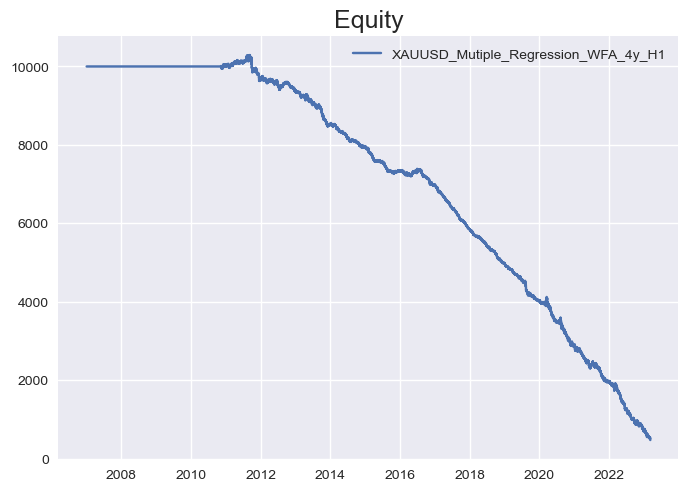

In [154]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [155]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [156]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [157]:
data = XAUUSD['H1']
window_size = 252 * 5 * 24
WFA = '5y'

In [158]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [159]:
test = ml.Run()

In [160]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   69.127345
Equity Final [$]                   866.738953
Equity Peak [$]                  10004.634317
Return [%]                          -91.33261
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                  -11.503518
Volatility (Ann.) [%]                5.184378
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -91.336625
Avg. Drawdown [%]                  -45.930392
Max. Drawdown Duration     4139 days 00:00:00
Avg. Drawdown Duration     2074 days 09:00:00
# Trades                                30418
Win Rate [%]                        44.174502
Best Trade [%]                       4.010433
Worst Trade [%]                     -6.911804
Avg. Trade [%]                    

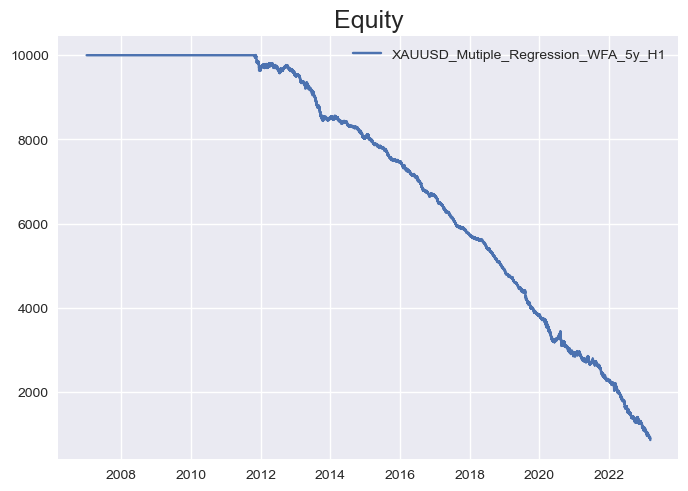

In [161]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [162]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [163]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [164]:
data = XAUUSD['H1']
window_size = 252 * 6 * 24
WFA = '6y'

In [165]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [166]:
test = ml.Run()

In [167]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   62.953019
Equity Final [$]                  1518.906903
Equity Peak [$]                   10009.13982
Return [%]                         -84.810931
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                    -8.98753
Volatility (Ann.) [%]                4.141521
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -84.824801
Avg. Drawdown [%]                  -12.161236
Max. Drawdown Duration     3781 days 06:00:00
Avg. Drawdown Duration      541 days 00:00:00
# Trades                                27002
Win Rate [%]                        44.037479
Best Trade [%]                       4.010433
Worst Trade [%]                     -5.531598
Avg. Trade [%]                    

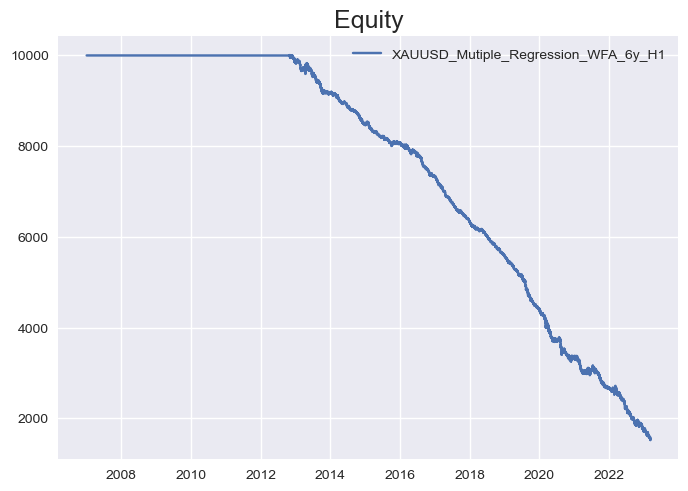

In [168]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [169]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [170]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [171]:
data = XAUUSD['H1']
window_size = 252 * 7 * 24
WFA = '7y'

In [172]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [173]:
test = ml.Run()

In [174]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   56.778692
Equity Final [$]                  2076.869341
Equity Peak [$]                  10011.198644
Return [%]                         -79.231307
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                   -7.553439
Volatility (Ann.) [%]                3.549536
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -79.254539
Avg. Drawdown [%]                   -26.44468
Max. Drawdown Duration     3419 days 11:00:00
Avg. Drawdown Duration     1140 days 01:00:00
# Trades                                24210
Win Rate [%]                        44.027261
Best Trade [%]                       4.262128
Worst Trade [%]                      -4.89349
Avg. Trade [%]                    

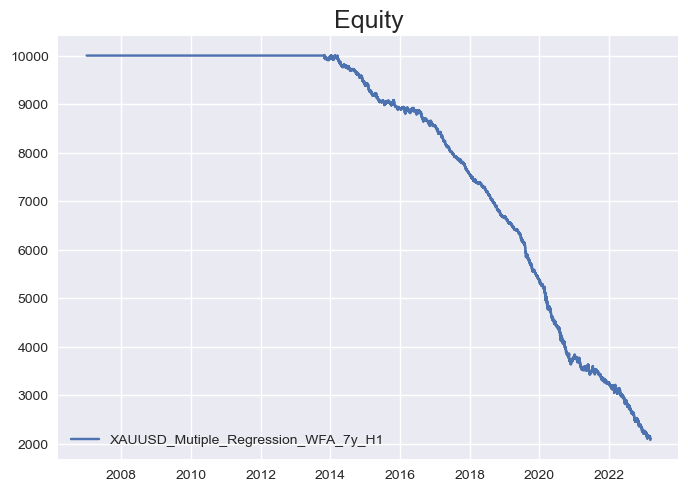

In [175]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [176]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [177]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [178]:
data = XAUUSD['H1']
window_size = 252 * 8 * 24
WFA = '8y'

In [179]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [180]:
test = ml.Run()

In [181]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   50.604365
Equity Final [$]                  3818.152128
Equity Peak [$]                  10010.574187
Return [%]                         -61.818479
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                   -4.697323
Volatility (Ann.) [%]                2.428214
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -61.85881
Avg. Drawdown [%]                  -30.937896
Max. Drawdown Duration     3054 days 12:00:00
Avg. Drawdown Duration     1527 days 13:00:00
# Trades                                22162
Win Rate [%]                        44.878621
Best Trade [%]                        4.85746
Worst Trade [%]                     -4.362633
Avg. Trade [%]                    

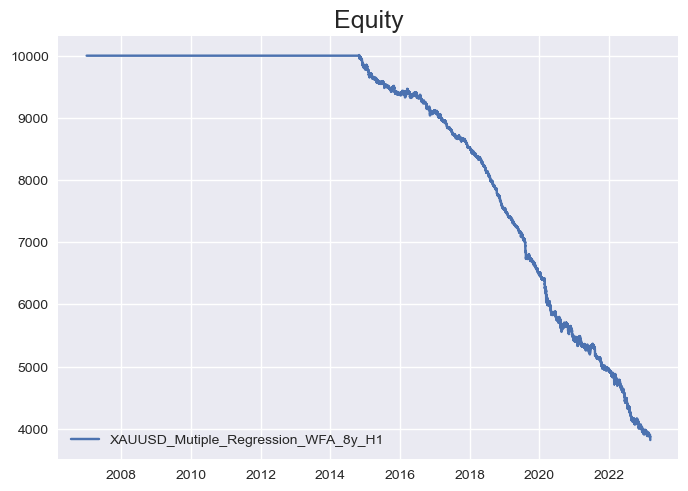

In [182]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [183]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [184]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF M30

In [14]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'M30'

### Window size 1 year

In [186]:
data = XAUUSD['M30']
window_size = 252 * 48
WFA = '1y'

In [187]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [188]:
test = ml.Run()

In [189]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   43.660782
Equity Final [$]                     6.477186
Equity Peak [$]                   10000.12183
Return [%]                         -99.935228
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -30.711021
Volatility (Ann.) [%]               19.314823
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.935229
Avg. Drawdown [%]                  -99.935229
Max. Drawdown Duration     5560 days 16:30:00
Avg. Drawdown Duration     5560 days 16:30:00
# Trades                                42603
Win Rate [%]                        44.196418
Best Trade [%]                       5.155632
Worst Trade [%]                     -3.831548
Avg. Trade [%]                    

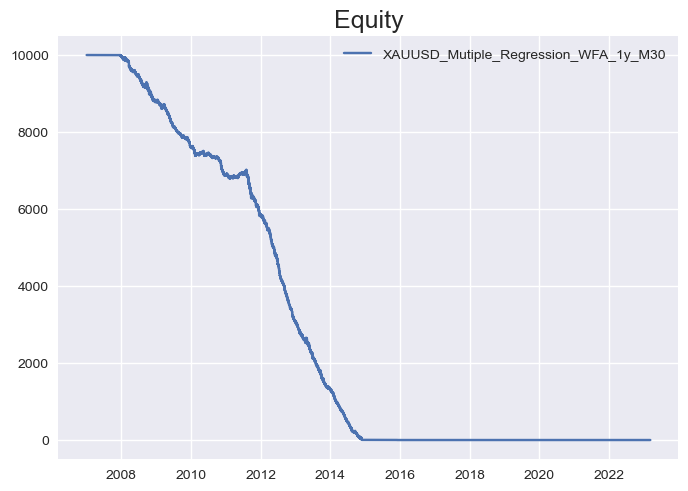

In [190]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [191]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [192]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [193]:
data = XAUUSD['M30']
window_size = 252 * 2 * 48
WFA = '2y'

In [194]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [195]:
test = ml.Run()

In [196]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   42.938582
Equity Final [$]                    10.286516
Equity Peak [$]                  10018.651641
Return [%]                         -99.897135
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                   -29.09085
Volatility (Ann.) [%]               14.581734
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.897326
Avg. Drawdown [%]                  -11.132355
Max. Drawdown Duration     5204 days 08:00:00
Avg. Drawdown Duration      578 days 17:24:00
# Trades                                40318
Win Rate [%]                        43.204028
Best Trade [%]                       4.484083
Worst Trade [%]                      -3.18678
Avg. Trade [%]                    

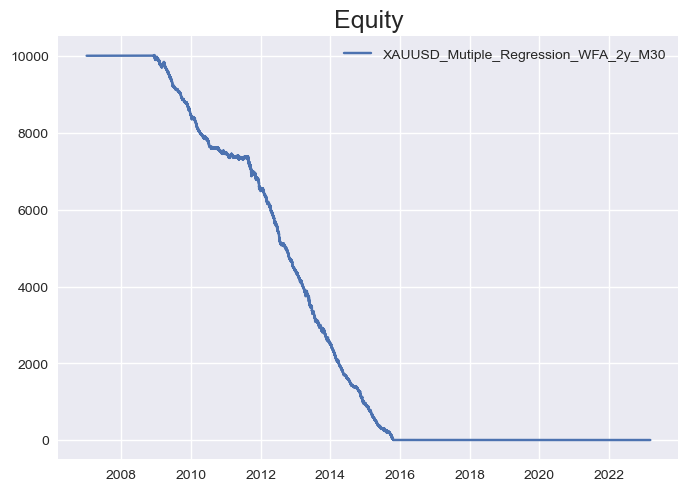

In [197]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [198]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [199]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [200]:
data = XAUUSD['M30']
window_size = 252 * 3 * 48
WFA = '3y'

In [201]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [202]:
test = ml.Run()

In [203]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   38.863535
Equity Final [$]                    10.328287
Equity Peak [$]                  10004.005431
Return [%]                         -99.896717
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -29.076489
Volatility (Ann.) [%]               17.381248
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.896858
Avg. Drawdown [%]                  -33.303828
Max. Drawdown Duration     4854 days 13:30:00
Avg. Drawdown Duration     1618 days 05:20:00
# Trades                                36673
Win Rate [%]                        43.238895
Best Trade [%]                       2.445126
Worst Trade [%]                     -5.200174
Avg. Trade [%]                    

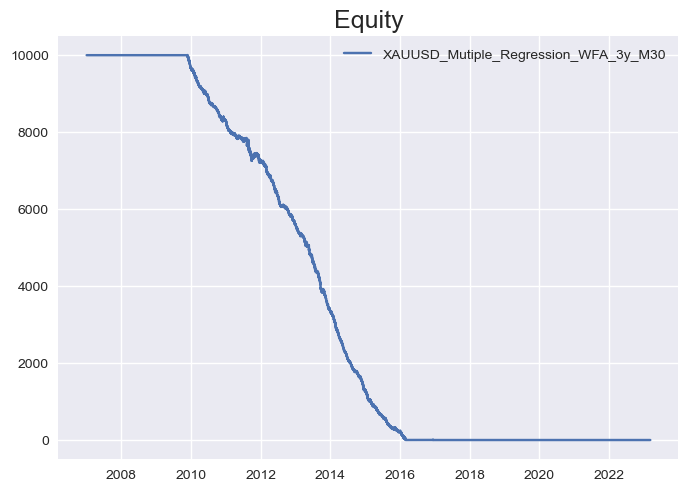

In [204]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [205]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [206]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [207]:
data = XAUUSD['M30']
window_size = 252 * 4 * 48
WFA = '4y'

In [208]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [209]:
test = ml.Run()

In [210]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   39.070975
Equity Final [$]                    11.506561
Equity Peak [$]                  10034.528395
Return [%]                         -99.884934
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -28.692584
Volatility (Ann.) [%]               13.931513
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -99.88533
Avg. Drawdown [%]                  -10.084905
Max. Drawdown Duration     4476 days 21:30:00
Avg. Drawdown Duration      450 days 05:57:00
# Trades                                38016
Win Rate [%]                        43.200231
Best Trade [%]                       2.248286
Worst Trade [%]                     -5.202944
Avg. Trade [%]                    

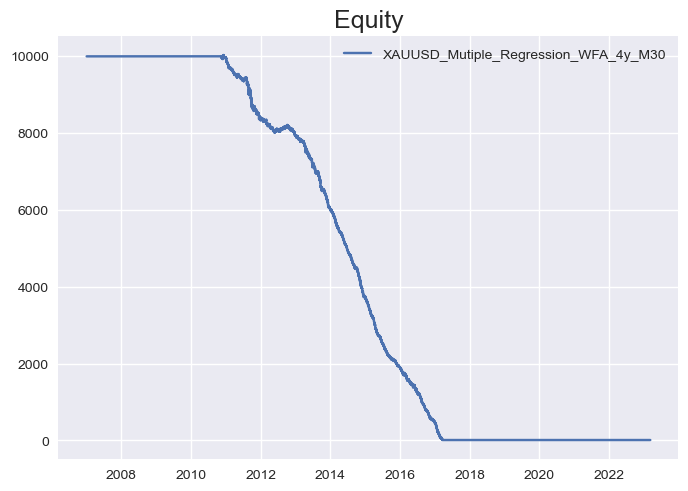

In [211]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [212]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [213]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [15]:
data = XAUUSD['M30']
window_size = 252 * 5 * 48
WFA = '5y'

In [16]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [17]:
test = ml.Run()

In [18]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   35.939397
Equity Final [$]                    11.535976
Equity Peak [$]                  10001.405959
Return [%]                          -99.88464
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -28.683487
Volatility (Ann.) [%]               14.775449
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.884656
Avg. Drawdown [%]                  -49.946641
Max. Drawdown Duration     4148 days 16:30:00
Avg. Drawdown Duration     2074 days 09:00:00
# Trades                                36534
Win Rate [%]                        42.563092
Best Trade [%]                        3.11407
Worst Trade [%]                      -4.76327
Avg. Trade [%]                    

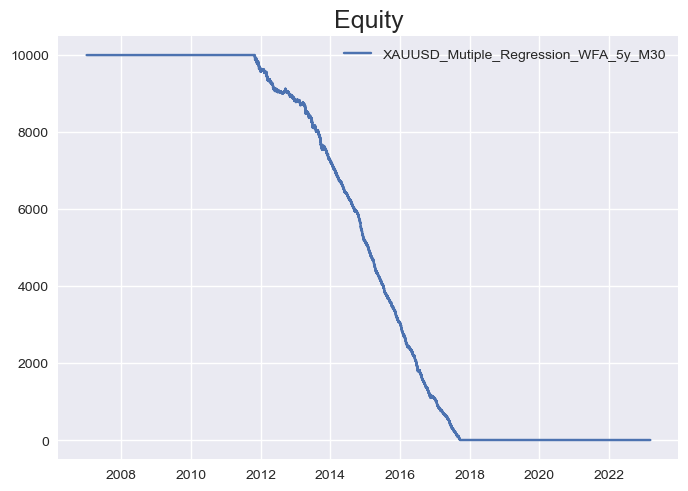

In [19]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [20]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [21]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [22]:
data = XAUUSD['M30']
window_size = 252 * 6 * 48
WFA = '6y'

In [23]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [24]:
test = ml.Run()

In [25]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   34.146704
Equity Final [$]                    10.968038
Equity Peak [$]                  10004.746167
Return [%]                          -99.89032
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -28.863174
Volatility (Ann.) [%]               14.069586
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.900557
Avg. Drawdown [%]                  -49.957425
Max. Drawdown Duration     3782 days 01:30:00
Avg. Drawdown Duration     1891 days 01:15:00
# Trades                                36284
Win Rate [%]                        42.170103
Best Trade [%]                       2.642468
Worst Trade [%]                     -4.034571
Avg. Trade [%]                    

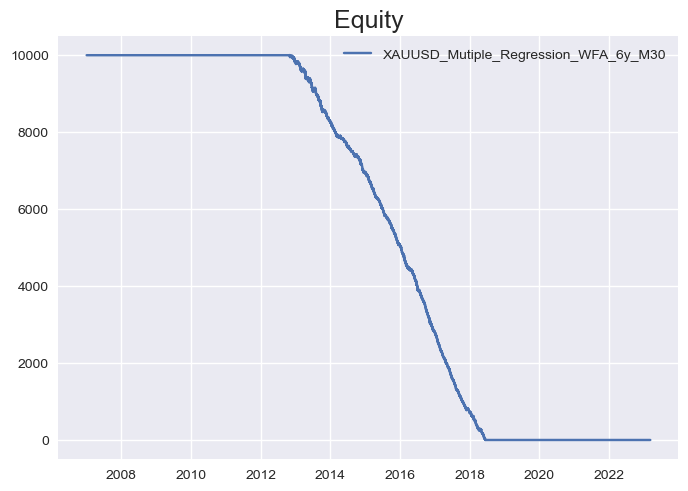

In [26]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [27]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [28]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [29]:
data = XAUUSD['M30']
window_size = 252 * 7 * 48 
WFA = '7y'

In [30]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [31]:
test = ml.Run()

In [32]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   34.085752
Equity Final [$]                    13.718144
Equity Peak [$]                  10032.893147
Return [%]                         -99.862819
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -28.063398
Volatility (Ann.) [%]               13.571383
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.875927
Avg. Drawdown [%]                   -7.159364
Max. Drawdown Duration     3409 days 09:00:00
Avg. Drawdown Duration      243 days 16:22:00
# Trades                                36351
Win Rate [%]                        41.665979
Best Trade [%]                       1.892002
Worst Trade [%]                     -4.361401
Avg. Trade [%]                    

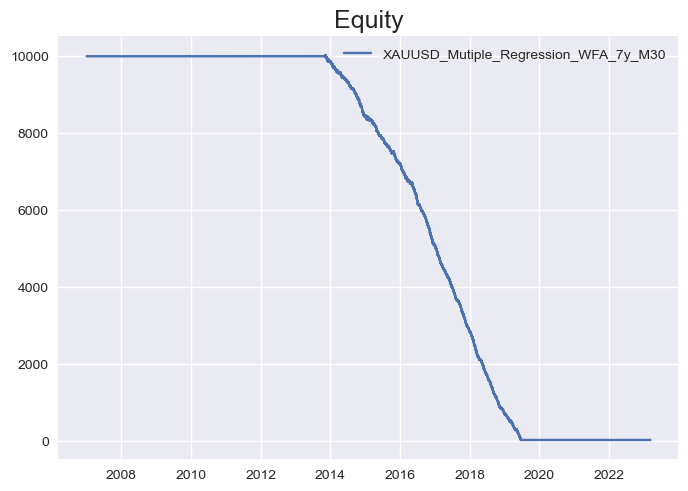

In [33]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [34]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [35]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [36]:
data = XAUUSD['M30']
window_size = 252 * 8 * 48
WFA = '8y'

In [37]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [38]:
test = ml.Run()

In [39]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   34.728561
Equity Final [$]                     6.931563
Equity Peak [$]                  10010.260741
Return [%]                         -99.930684
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -30.475876
Volatility (Ann.) [%]                42.05486
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.930755
Avg. Drawdown [%]                  -12.512771
Max. Drawdown Duration     3039 days 12:30:00
Avg. Drawdown Duration      380 days 02:04:00
# Trades                                37565
Win Rate [%]                         42.12698
Best Trade [%]                       2.824602
Worst Trade [%]                     -4.362633
Avg. Trade [%]                    

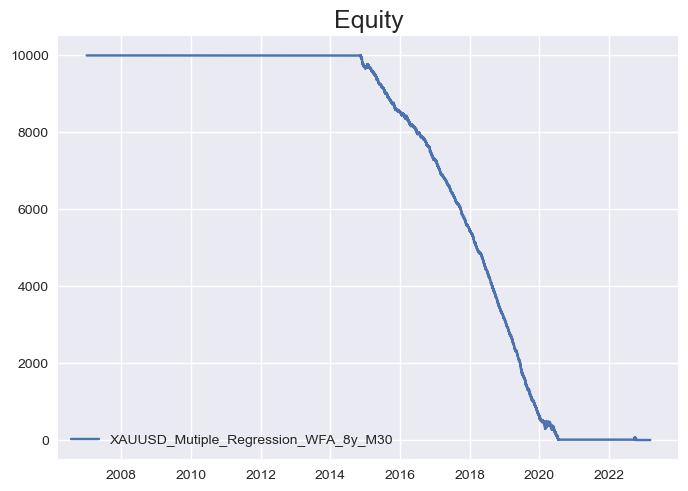

In [40]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [41]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [42]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')